In [1]:
from statistics import mean
import numpy as np
import pandas as pd
from imblearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from mlxtend.evaluate import accuracy_score, bias_variance_decomp
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

pd.options.mode.chained_assignment = None
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn import preprocessing, svm
from imblearn.over_sampling import RandomOverSampler

Read dataset from local directory and drop id column

In [2]:
stroke_df = pd.read_excel(r"C:\Users\rinat\OneDrive\Desktop\SCHOOL STUFF\Machine Learning\stroke_data.xlsx")
stroke_df = stroke_df.drop(['id'], axis=1)

Apply whitespace remover

In [3]:
def whitespace_remover(dataframe):
    for i in dataframe.columns:
        if dataframe[i].dtype == 'object':
            dataframe[i] = dataframe[i].map(str.strip)
        else:
            pass

# applying whitespace_remover function on dataframe
whitespace_remover(stroke_df)


Apply encoding and impute NaN values

In [4]:
# Apply One Hot Encoder
stroke_df = pd.get_dummies(stroke_df)

# Impute NaN values
stroke_df = stroke_df.fillna(1000000000)
stroke_df = stroke_df.replace(100000000, np.nan)
imputer = KNNImputer(n_neighbors=5)
stroke_df = pd.DataFrame(imputer.fit_transform(stroke_df), columns=stroke_df.columns)
print(stroke_df)

       age  hypertension  heart_disease  avg_glucose_level           bmi  \
0     67.0           0.0            1.0             228.69  3.660000e+01   
1     61.0           0.0            0.0             202.21  1.000000e+09   
2     80.0           0.0            1.0             105.92  3.250000e+01   
3     49.0           0.0            0.0             171.23  3.440000e+01   
4     79.0           1.0            0.0             174.12  2.400000e+01   
...    ...           ...            ...                ...           ...   
5105  80.0           1.0            0.0              83.75  1.000000e+09   
5106  81.0           0.0            0.0             125.20  4.000000e+01   
5107  35.0           0.0            0.0              82.99  3.060000e+01   
5108  51.0           0.0            0.0             166.29  2.560000e+01   
5109  44.0           0.0            0.0              85.28  2.620000e+01   

      stroke  gender_Female  gender_Male  gender_Other  ever_married_No  ...  \
0      

Visualize y class with imbalance

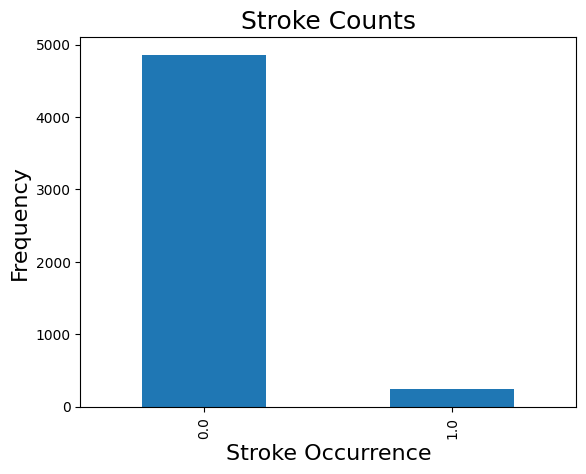

In [5]:
#Visualize y class
stroke_df['stroke'].value_counts().plot.bar()
plt.title('Stroke Counts', fontsize=18)
plt.xlabel('Stroke Occurrence', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.show()

In [6]:
# Drop target column
features_stroke = pd.DataFrame(stroke_df).drop(['stroke'], axis=1)

In [7]:
# Set X and Y
X = features_stroke
X_normalized = preprocessing.normalize(X, norm='l2')
stroke_target_cols = ['stroke']
y = (stroke_df[stroke_target_cols].astype(int).values.ravel())

In [8]:
# Apply Oversampling
ros = RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(X_normalized, y)

Visualize y class after oversampling

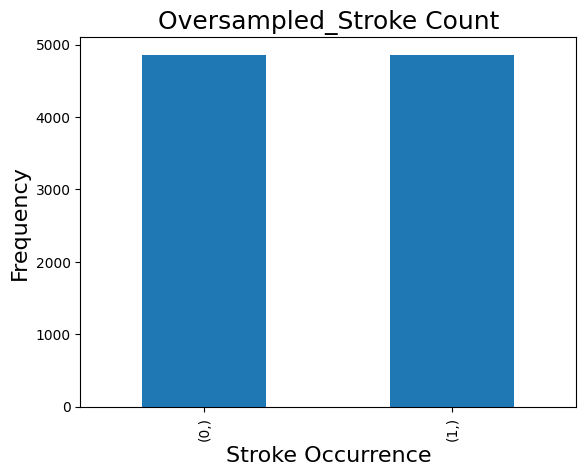

In [9]:
target = pd.DataFrame(y_ros)
target.value_counts().plot.bar()
plt.title('Oversampled_Stroke Count', fontsize=18)
plt.xlabel('Stroke Occurrence', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.show()

In [10]:
# Create Test/Train split
X_train, X_test, y_train, y_test = train_test_split(x_ros, y_ros, test_size=0.2,
                                                    random_state=42) 

In [11]:
# Apply svm classifier
clf = svm.SVC(decision_function_shape='ovo')

In [12]:
# Train the model using the training sets
clf.fit(X_train, y_train)

SVC(decision_function_shape='ovo')

In [13]:
# Predict the response for test dataset
y_pred = clf.predict(X_test)

This creates the RFE pipline to select features to use in classification

In [14]:
# Create RFE pipeline
rfe = RFECV(estimator=DecisionTreeClassifier(random_state=42))
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s', rfe), ('m', model)])

In [15]:
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=5)
n_scores = cross_val_score(pipeline, x_ros, y_ros, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

In [16]:
# report performance
print((mean(n_scores)))

0.9630042703050963


In [17]:
# summarize all features
rfe.fit(X,y)
feature_cols = []
for i, j in zip(range(X.shape[1]), X.columns):
    if rfe.support_[i] == True:
        feature_cols.append(j)
        print(i, rfe.support_[i], rfe.ranking_[i])
print(feature_cols)

0 True 1
3 True 1
4 True 1
['age', 'avg_glucose_level', 'bmi']


This section uses selected features to predict whether a patient has a stroke

In [18]:
# Set X and Y
X = (stroke_df[feature_cols].astype(int))
X_normalized = preprocessing.normalize(X, norm='l2')
target_cols = ['stroke']
y = (stroke_df[target_cols].astype(int).values.ravel())

In [19]:
# Set training and testing split
X_train, X_test, y_train, y_test = train_test_split(x_ros, y_ros, test_size=0.26, random_state=1)

This section uses NeighborhoodComponentsAnalysis and KNeighborsClassifier. Other estimators to use in binary classification, which were tested are:
LogisticRegression()
Svm()
GaussianNB()
RandomForestClassifier()
DecisionTreeClassifier()

In [20]:
# kNN
nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=10)
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(x_ros, y_ros)

Pipeline(steps=[('nca', NeighborhoodComponentsAnalysis(random_state=42)),
                ('knn', KNeighborsClassifier(n_neighbors=10))])

In [21]:
# Predict the response for test dataset
y_pred = nca_pipe.predict(X_test)

This section reports the results of the classification

In [22]:
# Produce Confusion Matrix
y_test_list = (list(y_test))
y_pred_list = (list(y_pred))
PP = []
PN = []
NN = []
NP = []
for i, j in zip(y_test_list, y_pred_list):
    if i == 0 and j == 0:
        NN.append(1)
    elif i == 1 and j == 0:
        PN.append(1)
    elif i == 0 and j == 1:
        NP.append(1)
    elif i == 1 and j == 1:
        PP.append(1)

print(len(PP), len(PN))
print(len(NP), len(NN))

1204 77
192 1055


In [102]:
# Test with user input
age = int(input("Enter age:"))
gender = str(input("Enter gender:"))
glucose = int(input("Enter avg_glucose_level:"))
bmi = int(input("Enter bmi:"))
hypertension = int(input("Enter hypertension 0 or 1:"))
heart_disease = int(input("Enter heart_disease 0 or 1:"))
ever_married = str(input("Enter marriage status, Yes or No:"))
work_type = str(input("Enter work_type:"))
Residence_type = str(input("Enter residence_type:"))
smoking_status = str(input("Enter smoking_status:"))


userInput = [age, gender,hypertension,heart_disease, ever_married, work_type, Residence_type, glucose, bmi,smoking_status]
user_list = list(userInput)

User = pd.DataFrame(columns = features_stroke.columns)
User = User.append(pd.Series(0, index=User.columns), ignore_index=True)
User['ind'] = range(1, len(User) + 1)

User2 = pd.DataFrame(columns=['age','gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi','smoking_status'], data=[user_list])
User2 = pd.get_dummies(User2)
User2['ind'] = range(1, len(User2) + 1)

User3 = pd.merge(User, User2, left_on='ind', right_on='ind', how='left')
User3_columns = list(User3.columns)

x = []
y = []
for i in User3_columns:
    if i.endswith("x"):
        x.append(i)
    else:
        y.append(i)

User3 = User3.drop(columns=x)
User3 = User3.drop('ind', axis=1)
display(User3)
X = User3.values.tolist()
X_list = X[0]

result = nca_pipe.predict([X_list])[0]
print("WILL THIS PERSON HAVE A STROKE? SEE BELOW (0 = NO, 1 = YES)")
print(result)

Enter age:50
Enter gender:Male
Enter avg_glucose_level:400
Enter bmi:49
Enter hypertension 0 or 1:1
Enter heart_disease 0 or 1:1
Enter marriage status, Yes or No:Yes
Enter work_type:Private
Enter residence_type:Urban
Enter smoking_status:smokes


C:\Users\rinat\AppData\Local\Temp\ipykernel_27232\3102997795.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  User = User.append(pd.Series(0, index=User.columns), ignore_index=True)


,gender_Female,gender_Other,ever_married_No,work_type_Govt_job,work_type_Never_worked,work_type_Self-employed,work_type_children,Residence_type_Rural,smoking_status_Unknown,smoking_status_formerly smoked,...,age_y,hypertension_y,heart_disease_y,avg_glucose_level_y,bmi_y,gender_Male_y,ever_married_Yes_y,work_type_Private_y,Residence_type_Urban_y,smoking_status_smokes_y
0,0,0,0,0,0,0,0,0,0,0,...,50,1,1,400,49,1,1,1,1,1


WILL THIS PERSON HAVE A STROKE? SEE BELOW (0 = NO, 1 = YES)
0


In [ ]:
# Get Accuracy Score
print(accuracy_score(y_test, y_pred))

In [100]:
# Estimate bias and variance
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(nca_pipe, X_train, y_train, X_test, y_test, loss='mse',
                                                            num_rounds=50, random_seed=20)


KeyboardInterrupt



In [ ]:
# Summary of the results
print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)